# Modelling and price prediction

With the exploratory data analysis now complete, I will attempt to build a model to predict the price of the listings based on the other features of the data available.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
# Import the dataset
df = pd.read_csv('C:/Users/freddie/PycharmProjects/Resume_Project/AB_NYC_2019.csv', encoding='utf_8')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [25]:
# Drop some potentially less interesting columns for the model dataframe
df_model = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
df_model

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,6,2


In [30]:
# Get rid of the null values in reviews_per_month and replace with 0
df_model = df_model.fillna({'reviews_per_month': 0})

In [31]:
# Check rest of dataframe for nulls
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               48895 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


We have eliminated the null values from the reviews per month, replacing them with zero as the real world cause of these values is the fact that there have been no reviews of the listings.

In [32]:
# Convert categorical features into binary one-hot encoded variables
df_dum = pd.get_dummies(df_model)
df_dum

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,9,0,1,...,0,0,0,0,0,0,0,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,36,0,1,...,0,0,0,0,0,0,0,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,27,0,0,...,0,0,0,0,0,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,2,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
# Split data into features (X) and labels (y)
X = df_dum.drop('price', axis =1)
y = df_dum.price.values

In [73]:
# Split data into a train set (80%) and a test set (20%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [74]:
# Start with a simple linear regression model
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
# Have a quick look at the coefficients
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
latitude,-9.864312e+01
longitude,-7.450842e+02
minimum_nights,-6.875149e-02
number_of_reviews,-2.412123e-01
reviews_per_month,-2.910590e+00
...,...
neighbourhood_Woodrow,0.000000e+00
neighbourhood_Woodside,-6.132335e+09
room_type_Entire home/apt,2.737332e+10
room_type_Private room,2.737332e+10


In [94]:
# Try the prediction on some validation data
cross_val_score(lm,X_train,y_train, scoring='neg_mean_absolute_error', cv=3)

array([   -53753.72968717,  -3665324.06888257, -10141401.69066696])

It seems we are getting errors due to the sparse nature of the predictors. Looking at the regression coefficients, we can see that some of the neighbourhood and room_type columns are generating high magnitude values. Lasso regression deals better with sparse predictors.

## Lasso Regression

In [91]:
# Try a lasso regression model
lm_l = Lasso(alpha=.16)
lm_l.fit(X_train,y_train)

Lasso(alpha=0.16, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [92]:
# Try the prediction on some validation data
cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)

array([-71.75229797, -71.19427952, -75.56039664])

These values seem much more reasonable, although the likelihood is that our biggest errors are on the top end of the price range (referring back to the histogram for price in the exploratory analysis). Removing some of these top price brackets going forward might help improve our accuracy at the lower price end. This will increase the usability of the model as clearly the vast majority of listings are on the lower end of the spectrum. 

To start with however, we will tune the lasso model parameter alpha to attempt to minimse our current error.

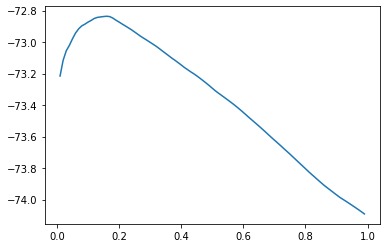

In [87]:
# Find mean absolute error associated with different values of alpha (alpha=0 is the same as linear regression)
alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100), max_iter=10000)
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

In [90]:
# Find alpha that gives the lowest error
err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

,alpha,error
15,0.16,-72.835658


Now that we have done that, we should consider a Random Forest Regressor. This model is based on binary decision trees so should cope well with the sparse binary data that we have in our predictors.

## Random Forest Regressor

In [102]:
# Try the random forest
rf = RandomForestRegressor()

In [103]:
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [98]:
# Try the model on some validation data
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-68.84002581630936

In [106]:
# Hyperparameter grid for tuning
parameters = {'n_estimators':range(10,300,10), 'max_depth':range(4,8,1)}

In [107]:
gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)

In [108]:
gs.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [109]:
# Lowest mean absolute error from the gridsearch 
gs.best_score_

-69.29192212806892

In [110]:
gs.best_estimator_
# n_estimators = 240, max_depth = 7

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Now we have our best estimator (at least by the number of trees in the forest and the maximum depth of trees), time to try out our models on the test data.

In [113]:
# Use the models on the test data
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

In [114]:
print('Mean Absolute Error (Linear Regression) is: ', mean_absolute_error(y_test,tpred_lm))
print('Mean Absolute Error (Lasso Regression) is: ', mean_absolute_error(y_test,tpred_lml))
print('Mean Absolute Error (Random Forest) is: ', mean_absolute_error(y_test,tpred_rf))


Mean Absolute Error (Linear Regression) is:  1645341.9411263582
Mean Absolute Error (Lasso Regression) is:  67.64314632272051
Mean Absolute Error (Random Forest) is:  64.29434136785713


## Evaluation of performance
As was the case with the training data, the linear regression model has yielded a meaningless response due to the sparsity of the data. The lasso regression performs more suitably with our estimate on average being ~ 67 US dollars away from the actual value. The best output was for the random forest which was out by ~ 64 US dollars. However, the time requirement for the random forest was far greater. In practice it may be more practical to use a lasso regression for this type of data if faster results are wanted. 

Normally at this stage the model would be considered complete, however it might be interesting to see whether a new model can be created to more accurately predict the price for the majority of listings by excluding the most expensive ones.

In [125]:
# Remove listings where price is $300 or greater
mask = df_model['price'] < 300

In [126]:
df_model2 = df_model[mask]
df_model2

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0.00,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2


In [127]:
# Encode the categorical data
df_dum2 = pd.get_dummies(df_model2)
df_dum2

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,9,0,1,...,0,0,0,0,0,0,0,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,36,0,1,...,0,0,0,0,0,0,0,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,27,0,0,...,0,0,0,0,0,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,2,0,0,...,0,0,0,0,0,0,0,0,0,1


In [128]:
# Features and labels
X2 = df_dum2.drop('price', axis =1)
y2 = df_dum2.price.values

In [131]:
# New train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

The new dataframe excluding listings over 300 US Dollars has now been created, and around 3000 listings have been removed. To save time, the best estimator parameters for the random forest will be reused here rather than computing new parameters.

In [133]:
# New model (using tuned hyperparameters)
rf2 = RandomForestRegressor(n_estimators=240, max_depth=7)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [134]:
# Try model on some validation data
np.mean(cross_val_score(rf2,X2_train,y2_train,scoring = 'neg_mean_absolute_error', cv= 3))

-30.322503249670103

In [135]:
# Predict on test data 
tpred_rf2 = rf2.predict(X2_test)

In [136]:
print('Mean Absolute Error (Random Forest 2) is: ', mean_absolute_error(y2_test,tpred_rf2))

Mean Absolute Error (Random Forest 2) is:  30.811891581477518


So removing the "outliers" (if you can call 3000 or so listings outliers!) meant that the model could predict the price to within ~30 US dollars on average for a listing. This is a good example of how having more data might not actually help in a predictive model, but rather data more relevant to the problem statement. 

Another interesting analysis might be analysing the names or descriptions of the listings, looking for keywords and how they might be an indication of price. For instance if you were adding a listing, knowing how the location being "quiet" or the the property being "cozy" affects the price might be useful to know. This would allow for an analysis of more subjective features of each listing. However, that may be another project for another time. 